In [8]:
from Bio.PDB import *
import os
import numpy as np
import common.res_infor
from utils.data import *
from utils.plot import *
from utils.dataset import *
import math
from diffusion_model.coordinate_diffusion_model import *

In [9]:
train_pdbs, train_pdb_chains = read_domain_ids_per_chain_from_txt('./data/train_domains.txt')
test_pdbs, test_pdb_chains = read_domain_ids_per_chain_from_txt('./data/test_domains.txt')

In [10]:
train_loader = CAcoordsDataLoader(train_pdb_chains, "./data/train_data_ca.npy","./data/train_data_res.npy", batch_size=32, shuffle=True)
test_loader = CAcoordsDataLoader(test_pdb_chains, "./data/test_data_ca.npy", "./data/test_data_res.npy", batch_size=32, shuffle=True)

## Visualization of C alpha atoms

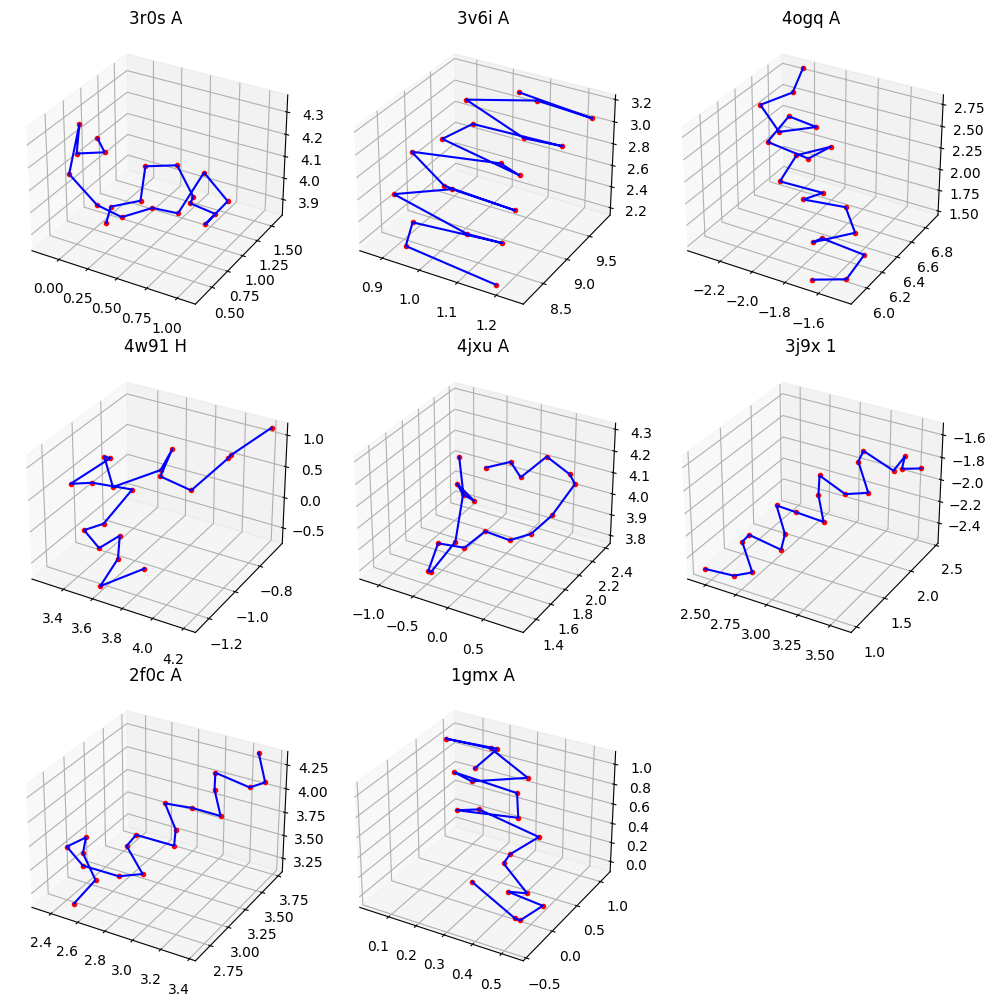

In [11]:
for batch_idx, (pdb_id, data, res) in enumerate(train_loader):
    pdb_chain = [(x[:4], x[4]) for x in pdb_id]
    show_Calpha_plots(pdb_chain[:8], data[:8]) 
    break

## Visualization of forward diffusion process

PDB id:3nnb A


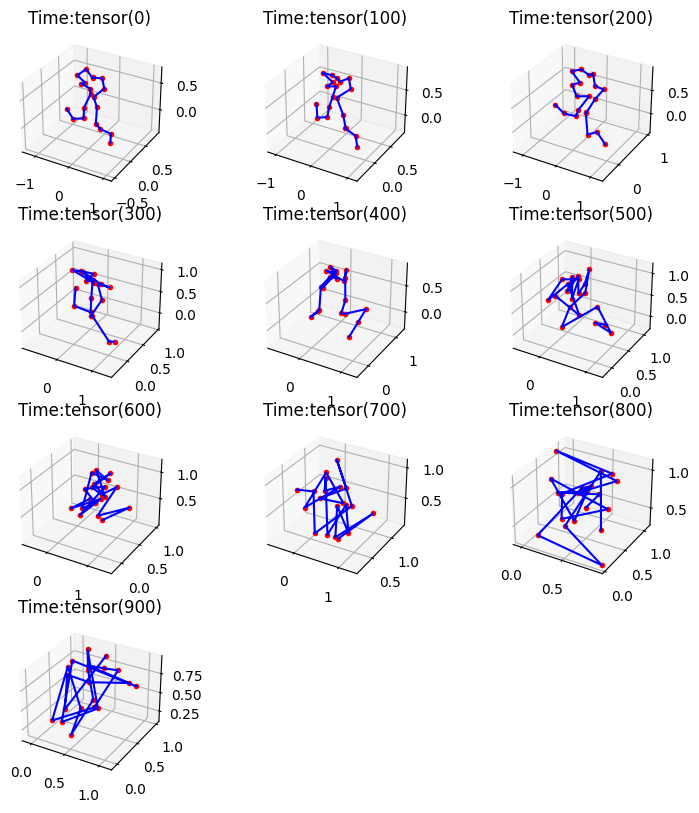

In [12]:
pdb_chain = next(iter(train_loader))[0][0]
ca_coords = next(iter(train_loader))[1][0]
ca_coords = ca_coords.reshape(1,20,3)
ddpm = Diffusion() # Defualt settings
show_foward_diffusion(ddpm, pdb_chain, ca_coords, 1000)

## Train model

In [13]:
def train(epoch: int, diffusion: nn.Module, eps_model: nn.Module, device, optimizer):
    eps_model.train()
    train_loss = 0.0
    for batch_idx, (_, data, _) in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device)
        data = data.unsqueeze(1) # dim: [128, 1, 20, 3]
        batch_size = data.shape[0]
        t = diffusion.sample_timesteps(batch_size = batch_size).to(device)
        x_t, eps = diffusion.q_sample(data, t)
        
        predicted_eps = eps_model(x = x_t.float(), t = t)
        optimizer.zero_grad()
        loss = F.smooth_l1_loss(predicted_eps, eps)
        train_loss += loss
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion = Diffusion(timesteps=100, beta_schedule='cosine', device=device)
eps_model = UNet(in_channels=1, out_channels=1, noise_steps=100, time_dim=128).to(device)
optimizer = optim.Adam(params=eps_model.parameters(), lr = 1e-3)
for epoch in range(1, 101):   
    train(epoch=epoch, diffusion=diffusion, eps_model=eps_model, device=device, optimizer=optimizer)



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 5.35 GiB already allocated; 0 bytes free; 5.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF